# Analysis of chemo diversity on pharmacological and biological activities

The [dataset](results/activities_2022-01-29_16-33-05.csv) is obtained from the Scopus downloader version 2.0 from the [base set](data/activities.csv) of chemical compounds and activities.

In [1]:
from pathlib import Path
from itertools import islice, product
from pprint import pprint

import pandas as pd
import numpy as np
from scipy import linalg
import prince
import holoviews as hv
import seaborn as sns
import matplotlib.pyplot as plt


import biblio_extractor as bex


np.set_printoptions(precision=4, suppress=True)


DATASET_FILENAME = Path("results/activities_2022-01-29_16-33-05.csv")

# MultiIndex levels
# level 0 is class (chemical, biological or pharmacological class)
# level 1 is name (compound or activity, a.k.a. keyword)
# level 2 is w/o w/ (with or without the keyword)

dataset = pd.read_csv(DATASET_FILENAME, index_col=[0, 1, 2], header=[0, 1, 2])
# dataset.index.names = ["class", "name", "with"]
# dataset.columns.names = ["class", "name", "with"]


all_compounds = set(dataset.index.get_level_values(1))
all_activities = set(dataset.columns.get_level_values(1))

assert dataset.shape == (2 * len(all_compounds), 2 * len(all_activities))
dataset


abiotic         \
                                                          antioxidant          
                                                                  w/o     w/   
alkaloid          acridine                            w/o      179092  62176   
                                                      w/         2430    266   
                  benzylamine                         w/o      180754  62371   
                                                      w/          768     71   
                  colchicine                          w/o      175968  62250   
...                                                               ...    ...   
terpenoid/terpene sesterterpene                       w/          182      7   
                  tetraterpene/carotenoid/xanthophyll w/o      178534  54855   
                                                      w/         2988   7587   
                  triterpene                          w/o      177099  61285   
                                                      w/         4423   1157   

                                                                         \
                                                          drought         
                                                              w/o    w/   
alkaloid          acridine                            w/o  240191  1077   
                                                      w/     2694     2   
                  benzylamine                         w/o  242046  1079   
                                                      w/      839     0   
                  colchicine                          w/o  237143  1075   
...                                                           ...   ...   
terpenoid/terpene sesterterpene                       w/      189     0   
                  tetraterpene/carotenoid/xanthophyll w/o  232655   734   
                                                      w/    10230   345   
                  triterpene                          w/o  237308  1076   
                                                      w/     5577     3   

                                                                          \
                                                            metal          
                                                              w/o     w/   
alkaloid          acridine                            w/o  216324  24944   
                                                      w/     2439    257   
                  benzylamine                         w/o  218089  25036   
                                                      w/      674    165   
                  colchicine                          w/o  213101  25117   
...                                                           ...    ...   
terpenoid/terpene sesterterpene                       w/      189      0   
                  tetraterpene/carotenoid/xanthophyll w/o  208780  24609   
                                                      w/     9983    592   
                  triterpene                          w/o  213234  25150   
                                                      w/     5529     51   

                                                                         \
                                                               uv         
                                                              w/o    w/   
alkaloid          acridine                            w/o  234781  6487   
                                                      w/     2616    80   
                  benzylamine                         w/o  236581  6544   
                                                      w/      816    23   
                  colchicine                          w/o  231671  6547   
...                                                           ...   ...   
terpenoid/terpene sesterterpene                       w/      189     0   
                  tetraterpene/carotenoid/xanthophyll w/o  227214  6175   


In [2]:

# sanity check : group by summing on level 2 on both rows and cols produce a matrix of constants : the number of papers
submatrix_sum = dataset.groupby(level=1).sum().groupby(level=1, axis=1).sum()
number_of_papers = np.unique(submatrix_sum.values)

# if the Scopus collection did not evolve during while querying
assert len(number_of_papers) == 1
number_of_papers = number_of_papers[0]
print(f"The domain contains {number_of_papers} papers")

The domain contains 243964 papers


Lets illustrate the content of this table. The sub matrix about _acridine_ and antioxidant is as follows

In [3]:
acridine_antioxidant_submatrix = dataset.loc[("alkaloid", "acridine",), ("abiotic", "antioxidant",)]
print(f"Among {number_of_papers} papers, there are")
for i,j in product(bex.SELECTORS, bex.SELECTORS):
    print(f"{acridine_antioxidant_submatrix.loc[i,j]} papers {i} acridine and {j} cytotoxicity in their keywords")

print("The acridine and cytotoxicity confusion matrix is as follows")
acridine_antioxidant_submatrix

Among 243964 papers, there are
179092 papers w/o acridine and w/o cytotoxicity in their keywords
62176 papers w/o acridine and w/ cytotoxicity in their keywords
2430 papers w/ acridine and w/o cytotoxicity in their keywords
266 papers w/ acridine and w/ cytotoxicity in their keywords
The acridine and cytotoxicity confusion matrix is as follows


C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


,w/o,w/
w/o,179092,62176
w/,2430,266


In [4]:
# the old matrix we had in version 1 : only the with/with queries
with_with_matrix = dataset.xs("w/", level=2).xs("w/", level=2, axis = 1)
with_with_matrix

abiotic          \
                                                      antioxidant drought   
alkaloid          acridine                                    266       2   
                  benzylamine                                  71       0   
                  colchicine                                  192       4   
                  cyclopeptide                                 57       1   
                  imidazole                                  1082       8   
                  indole                                     1324      53   
                  indolizidine                                  1       0   
                  isoquinoline                                138       2   
                  isoxazole                                   127       2   
                  muscarine                                     2       0   
                  oxazole                                      71       1   
                  phenylethylamine                              3       0   
                  piperidine                                  577       1   
                  purine                                      361      19   
                  putrescine                                  197      59   
                  pyridine                                   1033       7   
                  pyrrolidine                                 769       0   
                  pyrrolizidine                                32       2   
                  quinazoline                                 133       0   
                  quinoline                                   560       4   
                  quinolizidine                                 3       1   
                  spermidine                                  259      43   
                  spermine                                    223      37   
                  thiazole                                    863       4   
                  tropane                                      21       2   
phenolic compound acetophenone                                485       3   
                  anthraquinone                               701       2   
                  biflavonoids                                400       1   
                  flavonoids                                25763     259   
                  isoflavanoids                                 0       0   
                  lignans                                     757       2   
                  naphthoquinone                              371       1   
                  phenol                                    27855     232   
                  phenolic acid                              1825      20   
                  phenylpropanoid                             357      48   
                  stilbene                                   2475       5   
                  tannin                                     5276      48   
                  xanthone                                    481       0   
polyketide        acetogenin                                   20       1   
                  ansamycin                                     4       0   
                  macrolide                                    71       3   
                  polyene                                      74       1   
                  polyether                                    25       1   
                  tetracycline                                466      14   
terpenoid/terpene diterpene                                   427       5   
                  hemiterpene                                  29      24   
                  monoterpene                                 188      50   
                  norisoprenoid                                18       1   
                  polyterpene                                   0       0   
                  sesquiterpene                               863      17   
                  sesterterpene                       

In [5]:
with_with_total = with_with_matrix.values.sum()
print(f"Total number of positive/positive occurences is {with_with_total} for {number_of_papers} papers (average={with_with_total/number_of_papers})")

Total number of positive/positive occurences is 383330 for 243964 papers (average=1.571256414880884)


We compute marginal sums on rows and cols

In [6]:
margin_idx = (bex.CLASS_SYMB, bex.MARGIN_SYMB, bex.SELECTORS[1])
margin_cols = dataset.groupby(level=1).sum().drop_duplicates().reset_index(drop=True)
margin_cols.index = pd.MultiIndex.from_tuples([margin_idx])
margin_cols


abiotic                                                            \
       antioxidant        drought         metal             uv          salt   
               w/o     w/     w/o    w/     w/o     w/     w/o    w/     w/o   
* Σ w/      181522  62442  242885  1079  218763  25201  237397  6567  230565   

               ... pharmaco                                             \
               ...    wound       anticancer       cytotoxicity          
           w/  ...      w/o    w/        w/o    w/          w/o     w/   
* Σ w/  13399  ...   237180  6784     239317  4647       203439  40525   

                      toxicity         
       sedative       toxicity         
            w/o    w/      w/o     w/  
* Σ w/   241473  2491   217898  26066  

[1 rows x 66 columns]

In [7]:
margin_rows = dataset.groupby(level=1, axis=1).sum().iloc[:, 0]
margin_rows.name = margin_idx
margin_rows = pd.DataFrame(margin_rows)
margin_rows


*
                                                                Σ
                                                               w/
alkaloid          acridine                            w/o  241268
                                                      w/     2696
                  benzylamine                         w/o  243125
                                                      w/      839
                  colchicine                          w/o  238218
...                                                           ...
terpenoid/terpene sesterterpene                       w/      189
                  tetraterpene/carotenoid/xanthophyll w/o  233389
                                                      w/    10575
                  triterpene                          w/o  238384
                                                      w/     5580

[106 rows x 1 columns]

In [8]:
# me way add those margin to the original dataset
dataset_margins = dataset.copy()
dataset_margins[margin_idx] = margin_rows
dataset_margins = dataset_margins.append(margin_cols).fillna(number_of_papers).astype(int)


In [9]:
# see https://en.wikipedia.org/wiki/Confusion_matrix
# /!\ quelle jungle /!\ 

def fowlkes_mallows(arr):
    arr = arr.reshape(2,2)
    return np.sqrt(arr[1][1]/(arr[1][1] + arr[0][1]) * arr[1][1]/(arr[1][1] + arr[1][0]))

def acc(arr):
    arr = arr.reshape(2,2)
    return (arr[1][1] + arr[0][0])/(arr.sum())

def x_score(arr):
    arr = arr.reshape(2,2)
    return (arr[1][1] + arr[0][0] - arr[0][1] - arr[1][0])/(arr.sum())


print(fowlkes_mallows(acridine_antioxidant_submatrix.values))
print(acc(acridine_antioxidant_submatrix.values))
print(x_score(acridine_antioxidant_submatrix.values))
acridine_antioxidant_submatrix

0.02050138919206106
0.7351822400026233
0.47036448000524667


,w/o,w/
w/o,179092,62176
w/,2430,266


In [10]:
# redimension the values to a 4D array 
C, A = len(all_compounds),len(all_activities)
print(C, A)
M = dataset.values.reshape((C, 2, A,2))
M = np.moveaxis(M, 1, -2)


53 33


We obtain the same as submatrix_sum

In [11]:
# M.sum(axis=(2,3)) or similarly
np.sum(M, axis=(2,3), keepdims=False)

array([[243964, 243964, 243964, ..., 243964, 243964, 243964],
       [243964, 243964, 243964, ..., 243964, 243964, 243964],
       [243964, 243964, 243964, ..., 243964, 243964, 243964],
       ...,
       [243964, 243964, 243964, ..., 243964, 243964, 243964],
       [243964, 243964, 243964, ..., 243964, 243964, 243964],
       [243964, 243964, 243964, ..., 243964, 243964, 243964]], dtype=int64)

In [12]:
# 1D is easier for apply_along_axis
M2 = M.reshape((C*A,4))

print(M2[0])
print(M[0,0])
print(acc(M[0,0]))
print(x_score(M[0,0]))
print(fowlkes_mallows(M[0,0]))
print("--")



for fnct in [acc, x_score, fowlkes_mallows]:
    confused = np.apply_along_axis(fnct, 1, M2).reshape((C, A))

    print(f"{fnct.__name__}: min={confused.min()} max={confused.max()} mean={confused.mean()} std={confused.std()}")
# np.apply_over_axes(f, M2, axes=1)
# confused




[179092  62176   2430    266]
[[179092  62176]
 [  2430    266]]
0.7351822400026233
0.47036448000524667
0.02050138919206106
--
acc: min=0.6547933301634667 max=0.9999467134495253 mean=0.9405968017720355 std=0.06441521243684442
x_score: min=0.3095866603269335 max=0.9998934268990507 mean=0.8811936035440711 std=0.12883042487368884
fowlkes_mallows: min=0.0 max=0.5044407910277573 mean=0.017856818585047087 std=0.034914328505564377


In [13]:
confused_df = pd.DataFrame(100*confused)
confused_df.index = with_with_matrix.index #  set([(x,y) for x,y,_ in dataset.index.to_list()])
confused_df.columns = with_with_matrix.columns
# confused_df.values = confused
# confused_df


-------Original-------
[0.3427428862346429, 0.1825993122411097]
(abiotic, antioxidant)        0.224472
(abiotic, drought)            0.003490
(abiotic, metal)              0.073370
(abiotic, uv)                 0.019641
(abiotic, salt)               0.039851
(allelopathy, antifeedant)    0.000610
(allelopathy, arbuscula)      0.000029
(allelopathy, attractant)     0.000344
(allelopathy, germination)    0.007899
(allelopathy, herbicidal)     0.000590
dtype: float64
[0.23198899954119204, 0.12359419688939736]
0.6768601446110587


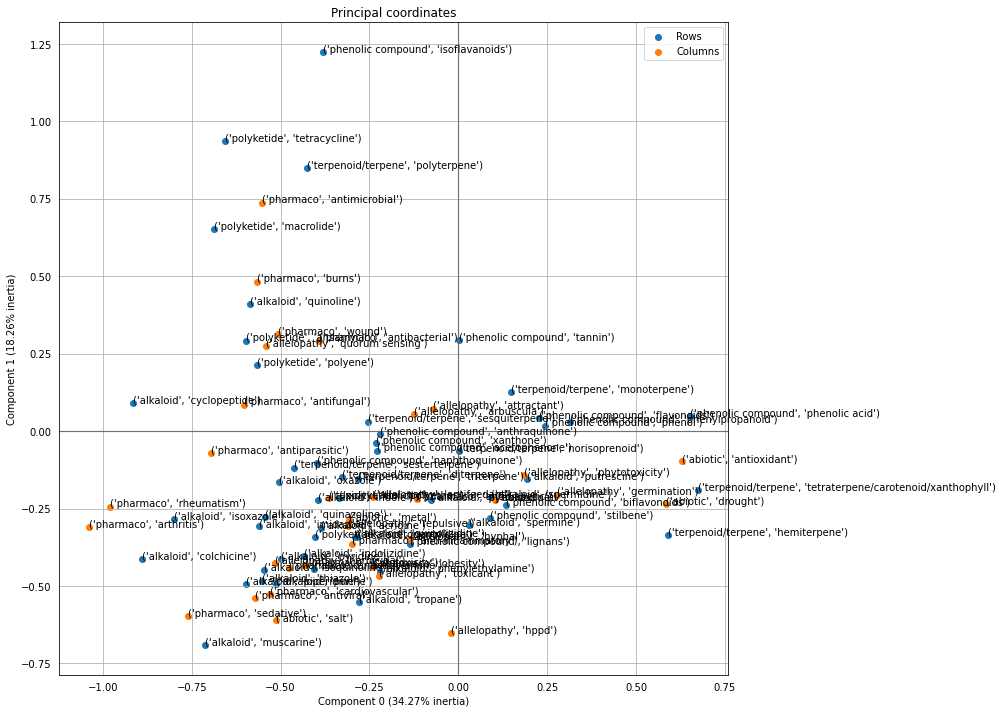

-------Confused-------
[0.18878888292916063, 0.11149644223652365]
(abiotic, antioxidant)        0.088243
(abiotic, drought)            0.017910
(abiotic, metal)              0.051138
(abiotic, uv)                 0.026104
(abiotic, salt)               0.045787
(allelopathy, antifeedant)    0.007592
(allelopathy, arbuscula)      0.001572
(allelopathy, attractant)     0.007395
(allelopathy, germination)    0.021154
(allelopathy, herbicidal)     0.006801
dtype: float64
[0.2144461571015702, 0.1266493195846254]
1.1359045817440265


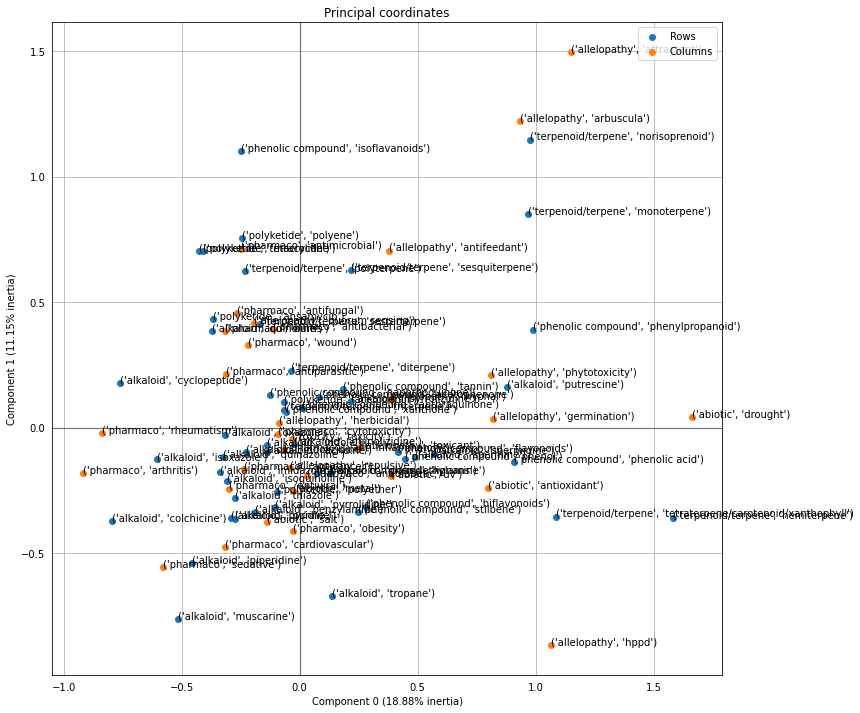

In [14]:

# TODO : les couleurs par classes

ca = prince.CA(n_components=2, n_iter=5, copy=True, check_input=True, engine="auto", random_state=42, benzecri=False)

for (df, name) in [(with_with_matrix, "Original"), (confused_df, "Confused")]:
    print(f"-------{name}-------")
    ca = ca.fit(df)

    # ca.row_coordinates(df)[:10]
    # ca.column_coordinates(df)[:10]

    pprint(ca.explained_inertia_)
    pprint(ca.col_masses_[:10])
    pprint(ca.eigenvalues_)
    pprint(ca.total_inertia_)

    ax = ca.plot_coordinates(
        X=confused_df,
        ax=None,
        figsize=(12, 12),
        x_component=0,
        y_component=1,
        show_row_labels=True,
        show_col_labels=True
    )
    plt.show()